<a href="https://colab.research.google.com/github/thap/skl-tf/blob/master/17_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Thu Feb 20 17:20:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

TensorFlow 2.x selected.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


# PCA with a linear Autoencoder

In [0]:
np.random.seed(4)

In [0]:
def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data
    

In [0]:
X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1.5))

In [0]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Train on 60 samples
Epoch 1/20
60/60 [==============================] - 2s 33ms/sample - loss: 0.3064
Epoch 2/20
60/60 [==============================] - 0s 288us/sample - loss: 0.3797
Epoch 3/20
60/60 [==============================] - 0s 196us/sample - loss: 0.1454
Epoch 4/20
60/60 [==============================] - 0s 184us/sample - loss: 0.0872
Epoch 5/20
60/60 [==============================] - 0s 217us/sample - loss: 0.0658
Epoch 6/20
60/60 [==============================] - 0s 150us/sample - loss: 0.0464
Epoch 7/20
60/60 [==============================] - 0s 209us/sample - loss: 0.0356
Epoch 8/20
60/60 [==============================] - 0s 171us/sample - loss: 0.0238
Epoch 9/20
60/60 [==============================] - 0s 119us/sample - loss: 0.0225
Epoch 10/20
60/60 [==============================] - 0s 182us/sample - loss: 0.0093
Epoch 11/20
60/60 [==============================] - 0s 158us/sample - loss: 0.0068
Epoch 12/20
60/60 [==============================] - 0s 118us/samp

In [0]:
codings = encoder.predict(X_train)

Saving figure Linear_autoencoder_pca_plot


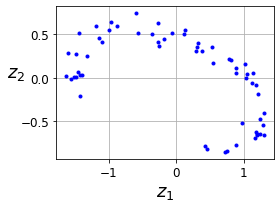

In [0]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:, 0], codings[:, 1], 'b.')
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18, rotation=0)
plt.grid(True)
save_fig('Linear_autoencoder_pca_plot')
plt.show()

# Stacked Autoencoders

In [0]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4423680/4422102 [==============================] - 0s 0us/step


## Train all layers at once

In [0]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [0]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])

In [0]:
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

In [0]:
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])


In [0]:
stacked_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.5),
                   metrics=[rounded_accuracy])


In [0]:
history = stacked_ae.fit(X_train, X_train, epochs=20, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 6s 106us/sample - loss: 0.3390 - rounded_accuracy: 0.8860 - val_loss: 0.3111 - val_rounded_accuracy: 0.9129
Epoch 2/20
55000/55000 [==============================] - 5s 95us/sample - loss: 0.3059 - rounded_accuracy: 0.9149 - val_loss: 0.3047 - val_rounded_accuracy: 0.9201
Epoch 3/20
55000/55000 [==============================] - 5s 96us/sample - loss: 0.2989 - rounded_accuracy: 0.9212 - val_loss: 0.3032 - val_rounded_accuracy: 0.9122
Epoch 4/20
55000/55000 [==============================] - 5s 97us/sample - loss: 0.2950 - rounded_accuracy: 0.9246 - val_loss: 0.2944 - val_rounded_accuracy: 0.9278
Epoch 5/20
55000/55000 [==============================] - 5s 97us/sample - loss: 0.2925 - rounded_accuracy: 0.9268 - val_loss: 0.2924 - val_rounded_accuracy: 0.9276
Epoch 6/20
55000/55000 [==============================] - 5s 99us/sample - loss: 0.2908 - rounded_accuracy: 0.9281 - val_loss

In [0]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [0]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for i in range(n_images):
        plt.subplot(2, n_images, 1 + i)
        plot_image(images[i])
        plt.subplot(2, n_images, 1 + n_images + i)
        plot_image(reconstructions[i])

Saving figure reconstruction_plot


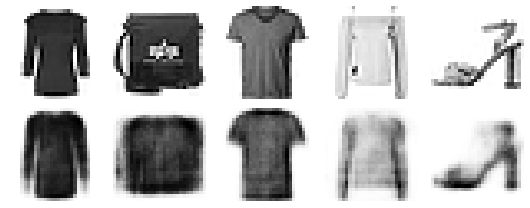

In [0]:
show_reconstructions(stacked_ae)
save_fig('reconstruction_plot')

# Visualizing Fashion MNIST

In [0]:
np.random.seed(42)

In [0]:
from sklearn.manifold import TSNE

In [0]:
X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

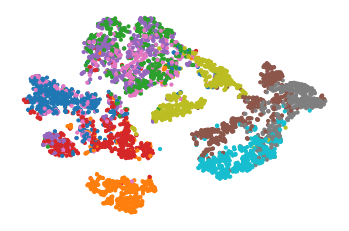

In [0]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap='tab10')
plt.axis('off')
plt.show()

Saving figure fashion_mnist_visualization_plot


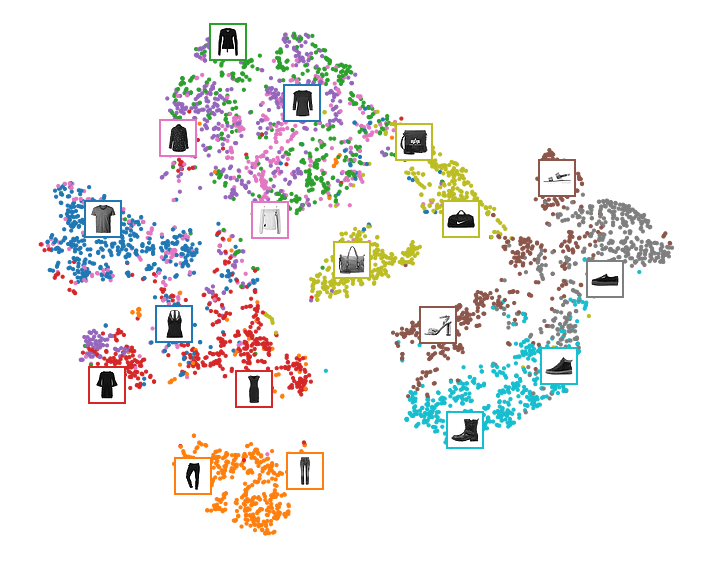

In [0]:
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02:
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap='binary'),
            position, bboxprops={'edgecolor': cmap(y_valid[index]), 'lw': 2}
        )
        plt.gca().add_artist(imagebox)
plt.axis('off')
save_fig('fashion_mnist_visualization_plot')
plt.show()

## Tying weights

In [0]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name='bias', shape=[self.dense.input_shape[-1]],
                                      initializer='zeros')
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [0]:
dense_1 = keras.layers.Dense(100, activation='selu')
dense_2 = keras.layers.Dense(30, activation='selu')

In [0]:
tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

In [0]:
tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation='selu'),
    DenseTranspose(dense_1, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

In [0]:
tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

In [0]:
tied_ae.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])

In [0]:
history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 106us/sample - loss: 0.3268 - rounded_accuracy: 0.8960 - val_loss: 0.3024 - val_rounded_accuracy: 0.9208
Epoch 2/10
55000/55000 [==============================] - 6s 103us/sample - loss: 0.2974 - rounded_accuracy: 0.9225 - val_loss: 0.2974 - val_rounded_accuracy: 0.9271
Epoch 3/10
55000/55000 [==============================] - 5s 98us/sample - loss: 0.2918 - rounded_accuracy: 0.9277 - val_loss: 0.2970 - val_rounded_accuracy: 0.9259
Epoch 4/10
55000/55000 [==============================] - 5s 96us/sample - loss: 0.2889 - rounded_accuracy: 0.9303 - val_loss: 0.2899 - val_rounded_accuracy: 0.9322
Epoch 5/10
55000/55000 [==============================] - 5s 99us/sample - loss: 0.2867 - rounded_accuracy: 0.9322 - val_loss: 0.2868 - val_rounded_accuracy: 0.9337
Epoch 6/10
55000/55000 [==============================] - 6s 101us/sample - loss: 0.2851 - rounded_accuracy: 0.9338 - val_lo

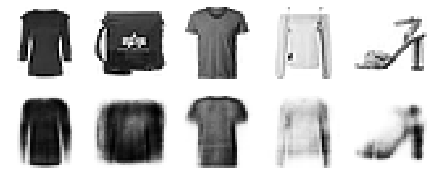

In [0]:
show_reconstructions(tied_ae)
plt.show()

## Training one Autoencoder at a Time

In [0]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation='selu', input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation)
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs, validation_data=[X_valid, X_valid])
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [0]:
K = keras.backend
X_train_flat = K.batch_flatten(X_train)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(100, X_train_flat, X_valid_flat, 
                                                           'binary_crossentropy', 
                                                           keras.optimizers.SGD(lr=1.5), 
                                                           output_activation='sigmoid', 
                                                           metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(30, X_train_enc1, X_valid_enc1, 'mse', 
                                     keras.optimizers.SGD(lr=0.05),
                                     output_activation='selu')

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 94us/sample - loss: 0.3446 - rounded_accuracy: 0.8873 - val_loss: 0.3123 - val_rounded_accuracy: 0.9148
Epoch 2/10
55000/55000 [==============================] - 5s 91us/sample - loss: 0.3040 - rounded_accuracy: 0.9202 - val_loss: 0.3008 - val_rounded_accuracy: 0.9248
Epoch 3/10
55000/55000 [==============================] - 5s 91us/sample - loss: 0.2951 - rounded_accuracy: 0.9284 - val_loss: 0.2936 - val_rounded_accuracy: 0.9314
Epoch 4/10
55000/55000 [==============================] - 5s 90us/sample - loss: 0.2893 - rounded_accuracy: 0.9340 - val_loss: 0.2889 - val_rounded_accuracy: 0.9357
Epoch 5/10
55000/55000 [==============================] - 5s 87us/sample - loss: 0.2855 - rounded_accuracy: 0.9376 - val_loss: 0.2859 - val_rounded_accuracy: 0.9387
Epoch 6/10
55000/55000 [==============================] - 5s 88us/sample - loss: 0.2829 - rounded_accuracy: 0.9401 - val_loss:

In [0]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

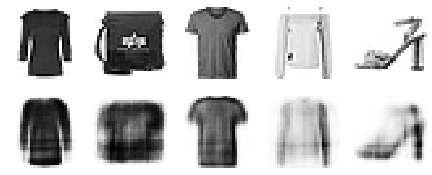

In [0]:
show_reconstructions(stacked_ae_1_by_1)

In [0]:
stacked_ae_1_by_1.compile(loss='binary_crossentropy', 
                          optimizer=keras.optimizers.SGD(lr=0.1), 
                          metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10, 
                                validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 113us/sample - loss: 0.2847 - rounded_accuracy: 0.9366 - val_loss: 0.2863 - val_rounded_accuracy: 0.9366
Epoch 2/10
55000/55000 [==============================] - 5s 95us/sample - loss: 0.2844 - rounded_accuracy: 0.9369 - val_loss: 0.2861 - val_rounded_accuracy: 0.9369
Epoch 3/10
55000/55000 [==============================] - 6s 102us/sample - loss: 0.2842 - rounded_accuracy: 0.9371 - val_loss: 0.2859 - val_rounded_accuracy: 0.9370
Epoch 4/10
55000/55000 [==============================] - 5s 98us/sample - loss: 0.2840 - rounded_accuracy: 0.9373 - val_loss: 0.2858 - val_rounded_accuracy: 0.9370
Epoch 5/10
55000/55000 [==============================] - 5s 99us/sample - loss: 0.2839 - rounded_accuracy: 0.9374 - val_loss: 0.2857 - val_rounded_accuracy: 0.9373
Epoch 6/10
55000/55000 [==============================] - 5s 97us/sample - loss: 0.2838 - rounded_accuracy: 0.9375 - val_los

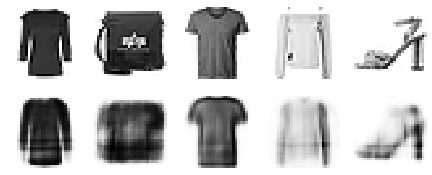

In [0]:
show_reconstructions(stacked_ae_1_by_1)

## Using Convolutional Layers Instead of Dense Layers

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [0]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding='SAME', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding='SAME', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='SAME', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2)
])

In [0]:
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='VALID', 
                                 activation='selu', input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='SAME', 
                                 activation='selu'),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='SAME',
                                 activation='sigmoid'),
    keras.layers.Reshape([28, 28])

])

In [0]:
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

In [0]:
conv_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 14s 248us/sample - loss: 0.3018 - rounded_accuracy: 0.9184 - val_loss: 0.2797 - val_rounded_accuracy: 0.9392
Epoch 2/5
55000/55000 [==============================] - 8s 137us/sample - loss: 0.2755 - rounded_accuracy: 0.9412 - val_loss: 0.2760 - val_rounded_accuracy: 0.9432
Epoch 3/5
55000/55000 [==============================] - 8s 139us/sample - loss: 0.2707 - rounded_accuracy: 0.9463 - val_loss: 0.2727 - val_rounded_accuracy: 0.9453
Epoch 4/5
55000/55000 [==============================] - 7s 132us/sample - loss: 0.2681 - rounded_accuracy: 0.9490 - val_loss: 0.2677 - val_rounded_accuracy: 0.9512
Epoch 5/5
55000/55000 [==============================] - 7s 132us/sample - loss: 0.2663 - rounded_accuracy: 0.9509 - val_loss: 0.2665 - val_rounded_accuracy: 0.9525


In [0]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)        

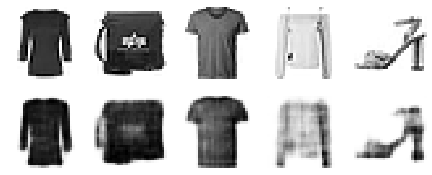

In [0]:
show_reconstructions(conv_ae)


# Recurrent Autoencoders

In [0]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])

In [0]:
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation='sigmoid'))
    
])

In [0]:
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

In [0]:
recurrent_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(0.1), 
                     metrics=[rounded_accuracy])

In [0]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 20s 360us/sample - loss: 0.5191 - rounded_accuracy: 0.7484 - val_loss: 0.4583 - val_rounded_accuracy: 0.8129
Epoch 2/10
55000/55000 [==============================] - 17s 304us/sample - loss: 0.4053 - rounded_accuracy: 0.8431 - val_loss: 0.3740 - val_rounded_accuracy: 0.8664
Epoch 3/10
55000/55000 [==============================] - 16s 299us/sample - loss: 0.3656 - rounded_accuracy: 0.8708 - val_loss: 0.3583 - val_rounded_accuracy: 0.8788
Epoch 4/10
55000/55000 [==============================] - 17s 300us/sample - loss: 0.3511 - rounded_accuracy: 0.8805 - val_loss: 0.3447 - val_rounded_accuracy: 0.8859
Epoch 5/10
55000/55000 [==============================] - 17s 303us/sample - loss: 0.3407 - rounded_accuracy: 0.8873 - val_loss: 0.3378 - val_rounded_accuracy: 0.8864
Epoch 6/10
55000/55000 [==============================] - 17s 302us/sample - loss: 0.3335 - rounded_accuracy: 0.8921

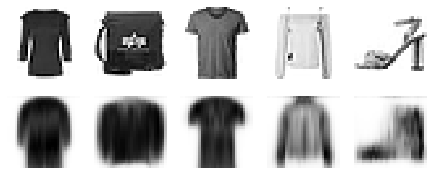

In [0]:
show_reconstructions(recurrent_ae)

# Stacked denoising Autoencoder

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [0]:
denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])

In [0]:
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

In [0]:
denoising_ae = keras.models.Sequential([
    denoising_encoder, denoising_decoder
])

In [0]:
denoising_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])

In [0]:
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 106us/sample - loss: 0.3513 - rounded_accuracy: 0.8763 - val_loss: 0.3179 - val_rounded_accuracy: 0.9066
Epoch 2/10
55000/55000 [==============================] - 5s 97us/sample - loss: 0.3126 - rounded_accuracy: 0.9093 - val_loss: 0.3079 - val_rounded_accuracy: 0.9165
Epoch 3/10
55000/55000 [==============================] - 6s 103us/sample - loss: 0.3058 - rounded_accuracy: 0.9150 - val_loss: 0.3030 - val_rounded_accuracy: 0.9191
Epoch 4/10
55000/55000 [==============================] - 5s 99us/sample - loss: 0.3021 - rounded_accuracy: 0.9183 - val_loss: 0.2999 - val_rounded_accuracy: 0.9232
Epoch 5/10
55000/55000 [==============================] - 5s 99us/sample - loss: 0.2991 - rounded_accuracy: 0.9209 - val_loss: 0.2969 - val_rounded_accuracy: 0.9253
Epoch 6/10
55000/55000 [==============================] - 6s 101us/sample - loss: 0.2968 - rounded_accuracy: 0.9230 - val_lo

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

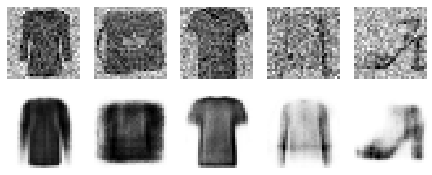

In [0]:
noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))


In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [0]:
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])

In [0]:
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

In [0]:
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])

In [0]:
dropout_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])

In [0]:
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 106us/sample - loss: 0.3572 - rounded_accuracy: 0.8703 - val_loss: 0.3193 - val_rounded_accuracy: 0.9052
Epoch 2/10
55000/55000 [==============================] - 5s 98us/sample - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3117 - val_rounded_accuracy: 0.9115
Epoch 3/10
55000/55000 [==============================] - 6s 100us/sample - loss: 0.3128 - rounded_accuracy: 0.9076 - val_loss: 0.3087 - val_rounded_accuracy: 0.9144
Epoch 4/10
55000/55000 [==============================] - 6s 101us/sample - loss: 0.3096 - rounded_accuracy: 0.9100 - val_loss: 0.3048 - val_rounded_accuracy: 0.9164
Epoch 5/10
55000/55000 [==============================] - 5s 100us/sample - loss: 0.3070 - rounded_accuracy: 0.9120 - val_loss: 0.3023 - val_rounded_accuracy: 0.9178
Epoch 6/10
55000/55000 [==============================] - 5s 98us/sample - loss: 0.3052 - rounded_accuracy: 0.9134 - val_l

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

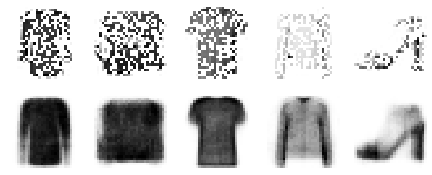

In [0]:
dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))

# Sparse Autoencoder

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [0]:
simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='sigmoid')
])

In [0]:
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

In [0]:
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])

In [0]:
simple_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.),
                  metrics=[rounded_accuracy])

In [0]:
history = simple_ae.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 109us/sample - loss: 0.4332 - rounded_accuracy: 0.7944 - val_loss: 0.3777 - val_rounded_accuracy: 0.8503
Epoch 2/10
55000/55000 [==============================] - 6s 103us/sample - loss: 0.3614 - rounded_accuracy: 0.8667 - val_loss: 0.3511 - val_rounded_accuracy: 0.8785
Epoch 3/10
55000/55000 [==============================] - 5s 100us/sample - loss: 0.3403 - rounded_accuracy: 0.8860 - val_loss: 0.3359 - val_rounded_accuracy: 0.8898
Epoch 4/10
55000/55000 [==============================] - 6s 102us/sample - loss: 0.3280 - rounded_accuracy: 0.8962 - val_loss: 0.3256 - val_rounded_accuracy: 0.9006
Epoch 5/10
55000/55000 [==============================] - 6s 102us/sample - loss: 0.3213 - rounded_accuracy: 0.9011 - val_loss: 0.3214 - val_rounded_accuracy: 0.9019
Epoch 6/10
55000/55000 [==============================] - 6s 102us/sample - loss: 0.3177 - rounded_accuracy: 0.9037 - val

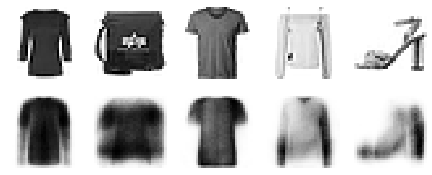

In [0]:
show_reconstructions(simple_ae)

In [0]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, position: '{}%'.format(int(np.round(100 * y)))))
    ax.grid(True)

In [0]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)
    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], 'k--', label='Overall Mean = {:.2f}'.format(mean))
    ax1.legend(loc='upper center', fontsize=14)
    ax1.set_xlabel('Activation')
    ax1.set_ylabel('% Activations')
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], 'k--')
    ax2.set_xlabel('Neuron Mean Activation')
    ax2.set_ylabel('% Neurons')
    ax2.axis([0, 1, 0, height])

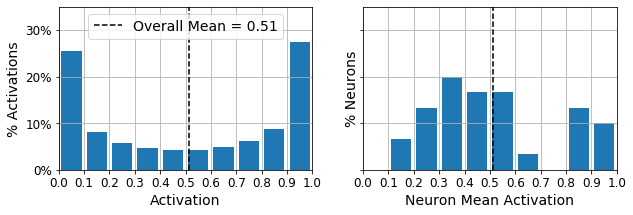

In [0]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [0]:
sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(300, activation='sigmoid'),
    keras.layers.ActivityRegularization(l1=1e-3)
])

In [0]:
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[300]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

In [0]:
sparse_l1_ae = keras.models.Sequential([
    sparse_l1_encoder, sparse_l1_decoder
])

In [0]:
sparse_l1_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.0), 
                     metrics=[rounded_accuracy])

In [0]:
history = sparse_l1_ae.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 7s 121us/sample - loss: 0.4311 - rounded_accuracy: 0.8128 - val_loss: 0.3809 - val_rounded_accuracy: 0.8564
Epoch 2/10
55000/55000 [==============================] - 6s 110us/sample - loss: 0.3691 - rounded_accuracy: 0.8687 - val_loss: 0.3639 - val_rounded_accuracy: 0.8750
Epoch 3/10
55000/55000 [==============================] - 6s 109us/sample - loss: 0.3546 - rounded_accuracy: 0.8799 - val_loss: 0.3504 - val_rounded_accuracy: 0.8859
Epoch 4/10
55000/55000 [==============================] - 6s 112us/sample - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3437 - val_rounded_accuracy: 0.8917
Epoch 5/10
55000/55000 [==============================] - 6s 110us/sample - loss: 0.3373 - rounded_accuracy: 0.8922 - val_loss: 0.3361 - val_rounded_accuracy: 0.8946
Epoch 6/10
55000/55000 [==============================] - 6s 110us/sample - loss: 0.3319 - rounded_accuracy: 0.8971 - val

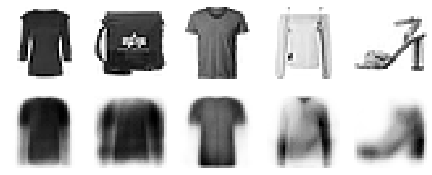

In [0]:
reconstructions = sparse_l1_ae.predict(X_valid[:5])
fig = plt.figure(figsize=(5 * 1.5, 3))
for image_index in range(5):
    plt.subplot(2, 5, 1 + image_index)
    plot_image(X_valid[image_index])
    plt.subplot(2, 5, 1 + 5 + image_index)
    plot_image(reconstructions[image_index])

[0, 1, 0, 1.0]

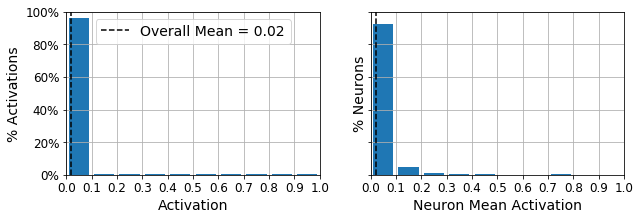

In [0]:
height = 1.0
n_bins = 10
X_valid_codings = sparse_l1_encoder(X_valid).numpy()
activation_means = X_valid_codings.mean(axis=0)
mean = activation_means.mean()
bins = np.linspace(0, 1, n_bins + 1)
fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
# plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
# def plot_percent_hist(ax, data, bins):
counts, _ = np.histogram(X_valid_codings.ravel(), bins=bins)
widths = bins[1:] - bins[:-1]
x = bins[:-1] + widths / 2
ax1.bar(x, counts / len(X_valid_codings.ravel()), width=widths*0.8)
ax1.xaxis.set_ticks(bins)
ax1.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, position: '{}%'.format(int(np.round(100 * y)))))
ax1.grid(True)
ax1.plot([mean, mean], [0, height], 'k--', label='Overall Mean = {:.2f}'.format(mean))
ax1.legend(loc='upper center', fontsize=14)
ax1.set_xlabel('Activation')
ax1.set_ylabel('% Activations')
ax1.axis([0, 1, 0, height])
plot_percent_hist(ax2, activation_means, bins)
ax2.plot([mean, mean], [0, height], 'k--')
ax2.set_xlabel('Neuron Mean Activation')
ax2.set_ylabel('% Neurons')
ax2.axis([0, 1, 0, height])

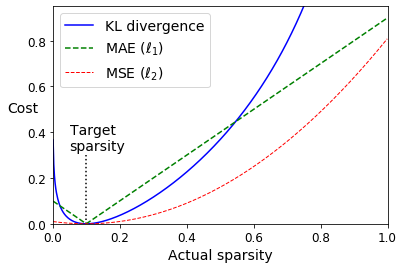

In [0]:
p = 0.1 
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p/q) + (1-p)*np.log((1-p)/(1-q))
mse = (p-q)**2
mae = np.abs(p-q)
plt.plot([p, p], [0, 0.3], 'k:')
plt.text(0.05, 0.32, 'Target\nsparsity', fontsize=14)
plt.plot(q, kl_div, 'b-', label='KL divergence')
plt.plot(q, mae, 'g--', label=r'MAE ($\ell_1$)')
plt.plot(q, mse, 'r--', linewidth=1, label=r'MSE ($\ell_2$)')
plt.legend(fontsize=14)
plt.xlabel('Actual sparsity')
plt.ylabel('Cost', rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.show()

In [0]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

In [0]:
class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (kl_divergence(self.target, mean_activities) + 
                              kl_divergence(1. - self.target, 1. - mean_activities))

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [0]:
kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)


In [0]:
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(300, activation='sigmoid', activity_regularizer=kld_reg)
])

In [0]:
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[300]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

In [0]:
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])


In [0]:
sparse_kl_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])

In [0]:
history = sparse_kl_ae.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 8s 141us/sample - loss: 0.4152 - rounded_accuracy: 0.8119 - val_loss: 0.3717 - val_rounded_accuracy: 0.8562
Epoch 2/10
55000/55000 [==============================] - 7s 135us/sample - loss: 0.3534 - rounded_accuracy: 0.8759 - val_loss: 0.3445 - val_rounded_accuracy: 0.8849
Epoch 3/10
55000/55000 [==============================] - 7s 127us/sample - loss: 0.3342 - rounded_accuracy: 0.8917 - val_loss: 0.3295 - val_rounded_accuracy: 0.8976
Epoch 4/10
55000/55000 [==============================] - 7s 132us/sample - loss: 0.3224 - rounded_accuracy: 0.9018 - val_loss: 0.3214 - val_rounded_accuracy: 0.9037
Epoch 5/10
55000/55000 [==============================] - 7s 127us/sample - loss: 0.3169 - rounded_accuracy: 0.9063 - val_loss: 0.3171 - val_rounded_accuracy: 0.9082
Epoch 6/10
55000/55000 [==============================] - 7s 134us/sample - loss: 0.3134 - rounded_accuracy: 0.9093 - val

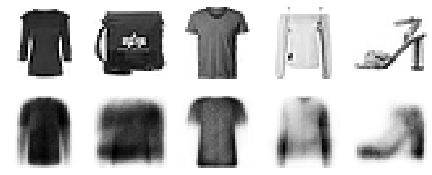

In [0]:
show_reconstructions(sparse_kl_ae)

Saving figure sparse_autoencoder_plot


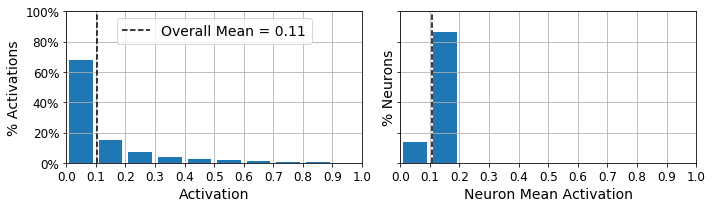

In [0]:
plot_activations_histogram(sparse_kl_encoder)
save_fig("sparse_autoencoder_plot")
plt.show()

# Variational Autoencoder

In [0]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var) + mean

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [0]:
codings_size = 10

In [0]:
inputs = keras.layers.Input(shape=[28, 28])

In [0]:
z = keras.layers.Flatten()(inputs)

In [0]:
z = keras.layers.Dense(150, activation='selu')(z)

In [0]:
z = keras.layers.Dense(100, activation='selu')(z)

In [0]:
codings_mean = keras.layers.Dense(codings_size)(z)

In [0]:
codings_log_var = keras.layers.Dense(codings_size)(z)

In [0]:
codings = Sampling()([codings_mean, codings_log_var])

In [0]:
variational_encoder = keras.models.Model(inputs=[inputs], 
                                         outputs=[codings_mean, 
                                                  codings_log_var, 
                                                  codings])

In [0]:
decoder_inputs = keras.layers.Input(shape=[codings_size])

In [0]:
x = keras.layers.Dense(100, activation='selu')(decoder_inputs)

In [0]:
x = keras.layers.Dense(150, activation='selu')(x)

In [0]:
x = keras.layers.Dense(28 * 28, activation='sigmoid')(x)

In [0]:
outputs = keras.layers.Reshape([28, 28])(x)

In [0]:
variational_decoder = keras.models.Model(inputs=[decoder_inputs],
                                         outputs=[outputs])

In [0]:
_, _, codings = variational_encoder(inputs)

In [0]:
reconstructions = variational_decoder(codings)

In [0]:
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

In [0]:
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)

In [0]:
variational_ae.add_loss(K.mean(latent_loss) / 784.)

In [0]:
variational_ae.compile(loss='binary_crossentropy', optimizer='rmsprop',
                       metrics=[rounded_accuracy])

In [0]:
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 64us/sample - loss: 0.3847 - rounded_accuracy: 0.8613 - val_loss: 0.3430 - val_rounded_accuracy: 0.8966
Epoch 2/25
55000/55000 [==============================] - 3s 49us/sample - loss: 0.3373 - rounded_accuracy: 0.8985 - val_loss: 0.3351 - val_rounded_accuracy: 0.8927
Epoch 3/25
55000/55000 [==============================] - 3s 48us/sample - loss: 0.3262 - rounded_accuracy: 0.9064 - val_loss: 0.3300 - val_rounded_accuracy: 0.9056
Epoch 4/25
55000/55000 [==============================] - 3s 49us/sample - loss: 0.3204 - rounded_accuracy: 0.9109 - val_loss: 0.3172 - val_rounded_accuracy: 0.9148
Epoch 5/25
55000/55000 [==============================] - 3s 49us/sample - loss: 0.3168 - rounded_accuracy: 0.9136 - val_loss: 0.3159 - val_rounded_accuracy: 0.9162
Epoch 6/25
55000/55000 [==============================] - 3s 52us/sample - loss: 0.3142 - rounded_accuracy: 0.9156 - val_loss:

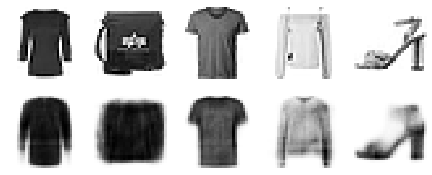

In [0]:
show_reconstructions(variational_ae)

# Generate Fashion Images 

In [0]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap='binary')
        plt.axis('off')

In [0]:
tf.random.set_seed(42)

In [0]:
codings = tf.random.normal(shape=[12, codings_size])

In [0]:
images = variational_decoder(codings).numpy()

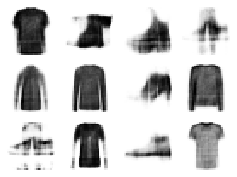

In [0]:
plot_multiple_images(images, 4)

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [0]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])

In [0]:
larger_grid = tf.image.resize(codings_grid, size=[5, 7])

In [0]:
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])

In [0]:
images = variational_decoder(interpolated_codings).numpy()

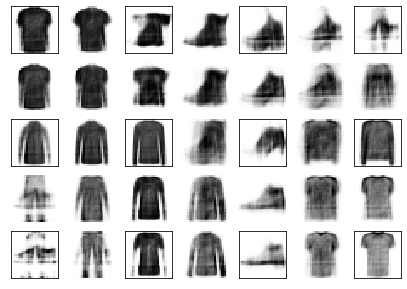

In [0]:
plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index % 7 % 2 == 0 and index // 7 % 2 == 0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis('off')
    plt.imshow(image, cmap='binary')

# Generative Adversarial Networks

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
codings_size = 30

In [0]:
generator = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[codings_size]),
    keras.layers.Dense(150, activation='selu'),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

In [0]:
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation='selu'),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
gan = keras.models.Sequential([generator, discriminator])

In [0]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [0]:
discriminator.trainable = False

In [0]:
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [0]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)

In [0]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [0]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=10):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print('Epochs {}/{}'.format(epoch + 1, n_epochs))
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)

Epochs 1/1


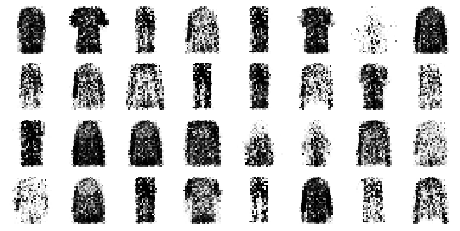

In [0]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [0]:
noise = tf.random.normal(shape=[batch_size, codings_size])

In [0]:
generated_images = generator(noise)

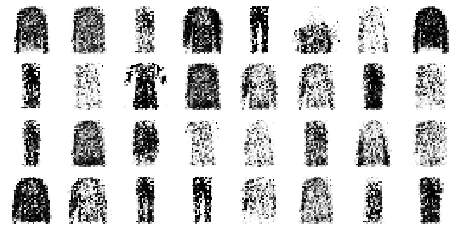

In [0]:
plot_multiple_images(generated_images, n_cols=8)

# Deep Convolutional GAN

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [0]:
codings_size = 100

In [0]:
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, 
                                 padding='SAME', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, 
                                 padding='SAME', activation='tanh')
])

In [0]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='SAME', 
                        activation=keras.layers.LeakyReLU(0.2), 
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='SAME', 
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
gan = keras.models.Sequential([generator, discriminator])

In [0]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [0]:
discriminator.trainable = False

In [0]:
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [0]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [0]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)

In [0]:
dataset = dataset.shuffle(1000)

In [0]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epochs 1/1


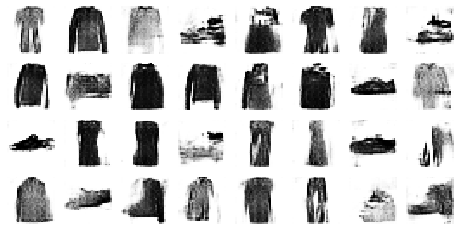

In [0]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [0]:
noise = tf.random.normal(shape=[batch_size, codings_size])

In [0]:
generated_images = generator(noise)

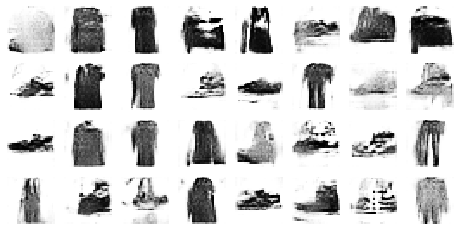

In [0]:
plot_multiple_images(generated_images, 8)

# Exercise Solutions

## Unsupervised pretraining

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [0]:
X_train_small = X_train[:500]
y_train_small = y_train[:500]

In [0]:
classifier = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding='SAME', 
                        activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding='SAME', 
                        activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='SAME', 
                        activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation='selu'),
    keras.layers.Dense(10, activation='softmax')
])

In [0]:
classifier.compile(loss='sparse_categorical_crossentropy', 
                   optimizer=keras.optimizers.SGD(lr=0.02), 
                   metrics=['accuracy'])

In [0]:
history = classifier.fit(X_train_small, y_train_small, epochs=20, 
                         validation_data=[X_valid, y_valid])

Train on 500 samples, validate on 5000 samples
Epoch 1/20
500/500 [==============================] - 0s 966us/sample - loss: 1.7706 - accuracy: 0.5180 - val_loss: 1.5392 - val_accuracy: 0.5944
Epoch 2/20
500/500 [==============================] - 0s 805us/sample - loss: 1.3725 - accuracy: 0.6240 - val_loss: 1.2739 - val_accuracy: 0.6338
Epoch 3/20
500/500 [==============================] - 0s 780us/sample - loss: 1.0802 - accuracy: 0.6780 - val_loss: 1.1240 - val_accuracy: 0.6336
Epoch 4/20
500/500 [==============================] - 1s 1ms/sample - loss: 0.9529 - accuracy: 0.7020 - val_loss: 1.1602 - val_accuracy: 0.5910
Epoch 5/20
500/500 [==============================] - 0s 834us/sample - loss: 0.8403 - accuracy: 0.7420 - val_loss: 0.8350 - val_accuracy: 0.7088
Epoch 6/20
500/500 [==============================] - 0s 785us/sample - loss: 0.7954 - accuracy: 0.7320 - val_loss: 0.7761 - val_accuracy: 0.7294
Epoch 7/20
500/500 [==============================] - 0s 775us/sample - loss: 0

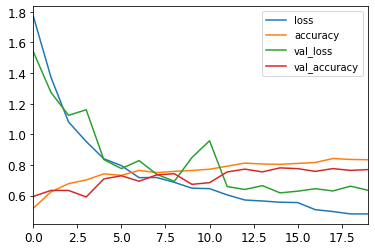

In [0]:
import pandas as pd
pd.DataFrame(history.history).plot()

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [0]:
conv_encoder_clone = keras.models.clone_model(conv_encoder)

In [0]:
pretrained_clf = keras.models.Sequential([
    conv_encoder_clone,
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation='selu'),
    keras.layers.Dense(10, activation='softmax')
])

In [0]:
conv_encoder_clone.trainable = False

In [0]:
pretrained_clf.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=['accuracy'])

In [0]:
history = pretrained_clf.fit(X_train_small, y_train_small, epochs=30,
                             validation_data=[X_valid, y_valid])

Train on 500 samples, validate on 5000 samples
Epoch 1/30
500/500 [==============================] - 1s 1ms/sample - loss: 2.3154 - accuracy: 0.1780 - val_loss: 2.2327 - val_accuracy: 0.2508
Epoch 2/30
500/500 [==============================] - 0s 750us/sample - loss: 2.1863 - accuracy: 0.2980 - val_loss: 2.1285 - val_accuracy: 0.3270
Epoch 3/30
500/500 [==============================] - 0s 753us/sample - loss: 2.0839 - accuracy: 0.3980 - val_loss: 2.0420 - val_accuracy: 0.3772
Epoch 4/30
500/500 [==============================] - 0s 777us/sample - loss: 1.9968 - accuracy: 0.4460 - val_loss: 1.9584 - val_accuracy: 0.4602
Epoch 5/30
500/500 [==============================] - 0s 804us/sample - loss: 1.9135 - accuracy: 0.5400 - val_loss: 1.8770 - val_accuracy: 0.5646
Epoch 6/30
500/500 [==============================] - 0s 810us/sample - loss: 1.8336 - accuracy: 0.6240 - val_loss: 1.7994 - val_accuracy: 0.6210
Epoch 7/30
500/500 [==============================] - 0s 739us/sample - loss: 1

In [0]:
conv_encoder_clone.trainable = True
pretrained_clf.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=['accuracy'])

In [0]:
history = pretrained_clf.fit(X_train_small, y_train_small, epochs=20, 
                             validation_data=[X_valid, y_valid])

Train on 500 samples, validate on 5000 samples
Epoch 1/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.8332 - accuracy: 0.7540 - val_loss: 0.8460 - val_accuracy: 0.6954
Epoch 2/20
500/500 [==============================] - 0s 850us/sample - loss: 0.7589 - accuracy: 0.7380 - val_loss: 0.7644 - val_accuracy: 0.7094
Epoch 3/20
500/500 [==============================] - 0s 800us/sample - loss: 0.6891 - accuracy: 0.7660 - val_loss: 0.7702 - val_accuracy: 0.7040
Epoch 4/20
500/500 [==============================] - 0s 804us/sample - loss: 0.6784 - accuracy: 0.7680 - val_loss: 0.8932 - val_accuracy: 0.6660
Epoch 5/20
500/500 [==============================] - 0s 813us/sample - loss: 0.6414 - accuracy: 0.7860 - val_loss: 0.7016 - val_accuracy: 0.7302
Epoch 6/20
500/500 [==============================] - 0s 802us/sample - loss: 0.6171 - accuracy: 0.7980 - val_loss: 0.6698 - val_accuracy: 0.7494
Epoch 7/20
500/500 [==============================] - 0s 791us/sample - loss: 0

## Hashing Using a Binary Autoencoder

In [0]:
tf.random.set_seed(42)
np.random.seed(42)


In [0]:
hashing_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.GaussianNoise(15.),
    keras.layers.Dense(16, activation='sigmoid')
])

In [0]:
hashing_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[16]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

In [0]:
hashing_ae = keras.models.Sequential([hashing_encoder, hashing_decoder])

In [0]:
hashing_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.0), 
                   metrics=[rounded_accuracy])

In [0]:
history = hashing_ae.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 112us/sample - loss: 0.4999 - rounded_accuracy: 0.7266 - val_loss: 0.4844 - val_rounded_accuracy: 0.7307
Epoch 2/10
55000/55000 [==============================] - 6s 114us/sample - loss: 0.4787 - rounded_accuracy: 0.7437 - val_loss: 0.4586 - val_rounded_accuracy: 0.7807
Epoch 3/10
55000/55000 [==============================] - 6s 108us/sample - loss: 0.4268 - rounded_accuracy: 0.8011 - val_loss: 0.4257 - val_rounded_accuracy: 0.8046
Epoch 4/10
55000/55000 [==============================] - 6s 109us/sample - loss: 0.4079 - rounded_accuracy: 0.8167 - val_loss: 0.4181 - val_rounded_accuracy: 0.8079
Epoch 5/10
55000/55000 [==============================] - 6s 108us/sample - loss: 0.4013 - rounded_accuracy: 0.8214 - val_loss: 0.4153 - val_rounded_accuracy: 0.8093
Epoch 6/10
55000/55000 [==============================] - 6s 104us/sample - loss: 0.3965 - rounded_accuracy: 0.8255 - val

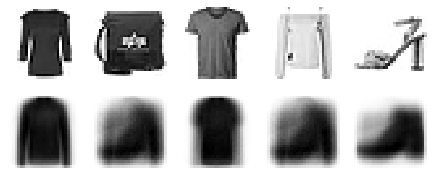

In [0]:
show_reconstructions(hashing_ae)

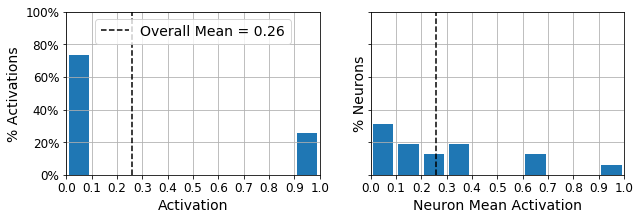

In [0]:
plot_activations_histogram(hashing_encoder)

In [0]:
hashes = np.round(hashing_encoder.predict(X_valid)).astype(np.int32)
hashes *= np.array([[2**bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print("{:016b}".format(h))
print("...")

0000100000001001
0000100000000000
0000100000011001
0000100000000000
0000100001000000
...


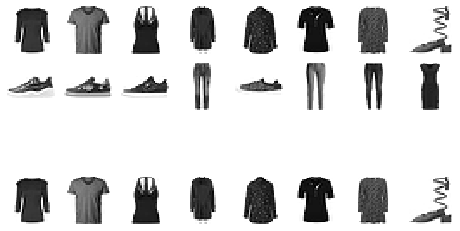

In [0]:
n_bits = 4
n_images = 8
plt.figure(figsize=(n_images, n_bits))
for bit_index in range(n_bits):
    in_bucket = (hashes & 2**bit_index != 0)
    for index, image in zip(range(n_images), X_valid[in_bucket]):
        plt.subplot(n_bits, n_images, bit_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")